In [ ]:
%pip install matplotlib librosa torch kagglehub
%pip install librosa --upgrade

In [ ]:
import os
import glob
import librosa
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt
import re
import kagglehub
import os
import glob

In [ ]:
# Downloading dataset
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)

In [5]:
print("music genres in the dataset:", list(os.listdir(f'{path}/Data/genres_original/')))
print("number of music genres:", len(list(os.listdir(f'{path}/Data/genres_original/'))))

music genres in the dataset: ['pop', 'metal', 'disco', 'blues', 'reggae', 'classical', 'rock', 'hiphop', 'country', 'jazz']
number of music genres: 10


In [6]:
# Define the directory path
directory = f'{path}/Data/genres_original/'
# Initialize a variable to store the minimum length
min_length = float('inf')
number_files = 0

# Iterate over all files in the directory
for genre in os.listdir(directory):
    genre_path = os.path.join(directory, genre)

    # Ensure it's a directory
    if os.path.isdir(genre_path):
        for filename in os.listdir(genre_path):
            if filename.endswith('.wav'):
                file_path = os.path.join(genre_path, filename)
                number_files += 1
                # Load the audio file using librosa
                y, sr = librosa.load(file_path)

                # Update the minimum length if needed
                min_length = min(min_length, len(y))

print(f"The minimum length of the music time series across all files is: {min_length}, it's corresponds to a minimum of {min_length/22050} seconds")
print("Number of files:", number_files)

The minimum length of the music time series across all files is: 660000, it's corresponds to a minimum of 29.931972789115648 seconds
Number of files: 999


In [7]:
# Define the directory path
directory = f'{path}/Data/genres_original/'
len_dataset = 0
dataset_filenames = []
# Iterate over all files in the directory
for genre in os.listdir(directory):
    genre_path = os.path.join(directory, genre)

    # Ensure it's a directory
    if os.path.isdir(genre_path):
        for filename in os.listdir(genre_path):
            if filename.endswith('.wav'):
                file_path = os.path.join(genre_path, filename)
                for i in range(min_length//1024):
                    dataset_filenames.append([file_path, i])
print(len(dataset_filenames))

643356


In [8]:
def extract_string(input_str):
    # Regular expression to capture the string between the first two slashes
    match = re.search(r'/([^/]+)/', input_str)
    if match:
        return match.group(1)
    else:
        return None

### Parameters and Configuration

In [68]:
AUDIO_DIR = f'{path}/Data/genres_original/'    # Directory containing audio files
SAMPLE_RATE = 22050
N_FFT = 1024
HOP_LENGTH = 512
N_MELS = 64     # Frequency bins for the Mel-spectrogram
DURATION = 10.0   # Duration of each audio clip in seconds (30s is the entire clip)
GENRES = ['blues','classical','country','disco','hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']  # Example classes
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps")

# ConvRBM Hyperparameters
VISIBLE_CHANNELS = 1  # Spectrogram is treated as a single "image" channel
HIDDEN_CHANNELS = 16  # Number of convolutional filters
KERNEL_SIZE = (8, 8)
LEARNING_RATE = 1e-3
CD_K = 1    # Contrastive divergence steps
EPOCHS = 1000
BATCH_SIZE = 64


In [10]:
class AudioDataset(Dataset):
    def __init__(self, audio_dir, genres, sample_rate=22050, duration=10.0, n_fft=2048, hop_length=512, n_mels=64):
        """
        Args:
            audio_dir (str): Path to the directory containing audio files organized by genre.
            genres (list of str): List of genre subfolder names.
            sample_rate (int): Sampling rate for audio loading.
            duration (float): Duration of audio to load (in seconds).
            n_fft (int): Number of FFT components.
            hop_length (int): Number of samples between successive frames.
            n_mels (int): Number of Mel bands.
        """
        self.sample_rate = sample_rate
        self.duration = duration
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels

        self.data = []
        self.labels = []
        self._load_audio_files(audio_dir, genres)

    def _load_audio_files(self, audio_dir, genres):
        for i, genre in enumerate(genres):
            genre_path = os.path.join(audio_dir, genre)
            for fname in glob.glob(os.path.join(genre_path, "*.wav")):
                try:
                    # Load audio
                    audio, sr = librosa.load(
                        fname, 
                        sr=self.sample_rate, 
                        duration=self.duration)

                    # Compute Mel-Spectrogram
                    mel_spec = librosa.feature.melspectrogram(
                        y=audio, 
                        sr=sr, 
                        n_fft=self.n_fft,
                        hop_length=self.hop_length, 
                        n_mels=self.n_mels)
                    # Convert to log scale for better dynamic range
                    log_mel = librosa.power_to_db(mel_spec, ref=np.max)
                    # Normalize to range [0, 1]
                    log_mel -= log_mel.min()
                    log_mel /= log_mel.max()

                    # Append data and label
                    self.data.append(log_mel)
                    self.labels.append(i)
                except Exception as e:
                    print(f"Error processing file {fname}: {e}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert data and labels to PyTorch tensors
        mel_tensor = torch.tensor(self.data[idx], dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.long)
        return mel_tensor, label_tensor

In [11]:
def split_dataset(audio_dir=AUDIO_DIR, genres=GENRES, n_mels=N_MELS, test_size=0.1, val_size=0.1, random_seed=14):
    # Create the full dataset
    dataset = AudioDataset(audio_dir, genres, n_mels=n_mels)
    print("dataset length", len(dataset))
    
    # Split indices for training, validation, and test sets
    total_size = len(dataset)
    indices = list(range(total_size))
    train_indices, test_indices = train_test_split(
        indices, test_size=test_size, random_state=random_seed)
    
    # Further split the training indices into training and validation
    train_indices, val_indices = train_test_split(
        train_indices, test_size=val_size / (1 - test_size), random_state=random_seed)
    
    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)
    test_subset = Subset(dataset, test_indices)
    
    return train_subset, val_subset, test_subset

def get_dataloaders(audio_dir, genres=GENRES, n_mels=64, batch_size=BATCH_SIZE, test_size=0.1, val_size=0.1, shuffle=True, random_seed=13):
    train_subset, val_subset, test_subset = split_dataset(
        audio_dir, genres, test_size=test_size, val_size=val_size, n_mels=n_mels, random_seed=random_seed)
    
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=shuffle)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

In [12]:
train_loader_64, val_loader_64, test_loader_64 = get_dataloaders(
    AUDIO_DIR, 
    genres=GENRES, 
    batch_size=BATCH_SIZE, 
    n_mels=N_MELS,
    shuffle=False)

dataset length 999


In [13]:
print("Number of training batches:", len(train_loader_64))
print("Number of validation batches:", len(val_loader_64))
print("Number of test batches:", len(test_loader_64))

Number of training batches: 13
Number of validation batches: 2
Number of test batches: 2


batch_X shape: torch.Size([64, 1, 64, 431])


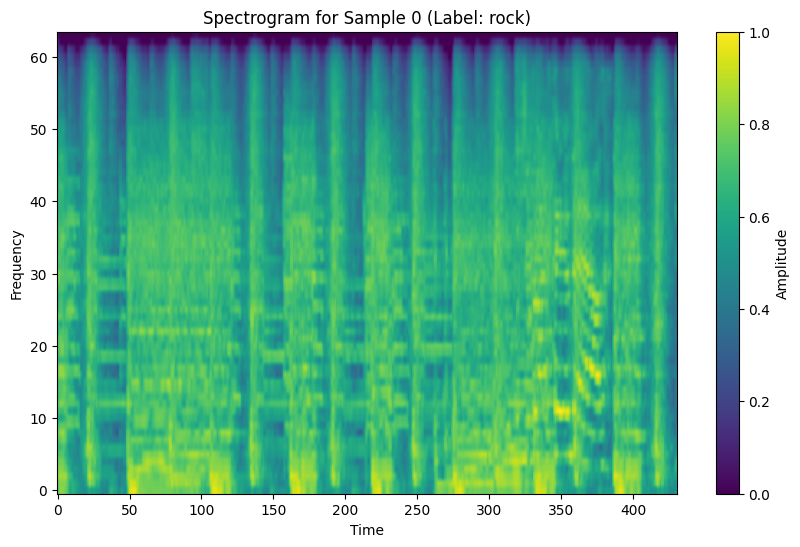

In [ ]:
# Function to visualize a spectrogram
def visualize_spectrogram(loader, sample_index=0):
    """
    Visualize a spectrogram from the given DataLoader.
    Args:
        loader (DataLoader): DataLoader containing the spectrograms.
        sample_index (int): Index of the sample to visualize within the first batch.
    """
    # Get the first batch from the DataLoader
    for batch_X, batch_y in loader:
        print("batch_X shape:", batch_X.shape)
        spectrogram = batch_X[sample_index].squeeze(0).cpu().numpy()
        label = GENRES[batch_y[sample_index].item()]
        break

    # Plot the spectrogram
    plt.figure(figsize=(10, 6))
    plt.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Amplitude')
    plt.title(f"Spectrogram for Sample {sample_index} (Label: {label})")
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.show()

# Call the function to visualize
visualize_spectrogram(train_loader_64, sample_index=0)

In [38]:
# Extract one sample from train_loader_64
for batch_X, batch_y in train_loader_64:
    _, _, dim_v_h, dim_v_w = batch_X.shape
    break

## ConvRBM

### ConvRBM model

In [94]:
class ConvRBM(nn.Module):
    def __init__(self, dim_v_w, dim_v_h, visible_channels, hidden_channels, kernel_size, cd_k, learning_rate=1e-4, batch_size=16):
        super(ConvRBM, self).__init__()
        self.dim_h_x = dim_v_w - kernel_size[0] + 1
        self.dim_h_y = dim_v_h - kernel_size[1] + 1

        self.kernel_size = kernel_size
        self.CD_k = cd_k
        self.batch_size = batch_size
        self.lr = learning_rate

        self.W = nn.Parameter(torch.empty(hidden_channels, visible_channels, kernel_size[0], kernel_size[1], dtype=torch.float32))
        nn.init.xavier_uniform_(self.W)
        self.v_bias = nn.Parameter(torch.zeros(size=[visible_channels, dim_v_h, dim_v_w], dtype=torch.float32))
        self.h_bias = nn.Parameter(torch.zeros(size=(hidden_channels, 1, 1), dtype=torch.float32))

        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

    def sample_h(self, v):
        # print("v shape: ", v.shape)
        # print("W shape: ", self.W.shape)
        conv = nn.functional.conv2d(v, self.W) 
        conv += self.h_bias
        h_prob = torch.sigmoid(conv)
        h_sample = torch.bernoulli(h_prob)
        return h_prob, h_sample
    
    def sample_v(self, h):
        # print("h shape: ", h.shape)
        # print("W shape: ", self.W.shape)
        conv = nn.functional.conv_transpose2d(h, self.W)
        conv += self.v_bias
        v_prob = torch.sigmoid(conv)
        v_sample = torch.bernoulli(v_prob) #TODO consider continous
        return v_prob, v_sample
    
    def contrastive_divergence(self, v):
        # positive phase
        v_pos_sample = v
        h_pos_prob, h_pos_sample = self.sample_h(v_pos_sample)
        h_step = h_pos_sample

        for _ in range(self.CD_k):
            # negative phase
            v_neg_prob, v_neg_sample = self.sample_v(h_step)
            h_neg_prob, h_neg_sample = self.sample_h(v_neg_sample)

            # print(f"v_neg shape: {v_neg_sample.shape}, h_neg shape: {h_neg_sample.shape}")

            # loop
            h_step = h_neg_sample

        error = torch.mean((v_pos_sample - v_neg_sample) ** 2)


        if self.training:
            self.optimizer.zero_grad()
            error.backward()
            self.optimizer.step()

        return error.item()

    def train_rbm(self, epochs, train_loader, val_loader, device='cpu', learning_rate=1e-3, save_interval=50, save_dir='./model_weights'):
        train_losses = []
        val_losses = []

        for epoch in range(epochs):
            
            self.train()
            with tqdm(train_loader, unit="batches") as pbar:
                train_loss = 0.0
                for X_train, _ in pbar:
                    X_train = X_train.to(device)
                    loss = self.contrastive_divergence(X_train)
                    train_loss += loss

            # Average training loss across all batches
            avg_train_loss = train_loss / len(train_loader)
            train_losses.append(avg_train_loss)


            self.eval()
            torch.no_grad()
            val_loss = 0.0
            with tqdm(val_loader, unit="batches") as pbar:
                loss = 0.0
                for X_test, _ in pbar:
                    X_test = X_test.to(device)
                    loss = self.contrastive_divergence(X_test)
                    val_loss += loss

            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            # Logging epoch summary
            print(f"Epoch [{epoch + 1}/{epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

            # Save model weights at intervals
            if (epoch + 1) % save_interval == 0:
                save_path = os.path.join(save_dir, f'rbm_epoch_{epoch + 1}.pth')
                torch.save(self.state_dict(), save_path)
                print(f"Model weights saved to {save_path}")

                # Plot training and validation loss
                plt.figure(figsize=(10, 6))
                plt.plot(range(epoch + 1), train_losses, label='Training Loss')
                plt.plot(range(epoch + 1), val_losses, label='Validation Loss')
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.title('Training and Validation Loss Over Epochs')
                plt.legend()
                plt.grid(True)
                
                

                # Plot training and validation loss in log scale
                plt.figure(figsize=(10, 6))
                plt.plot(range(epoch + 1), train_losses, label='Training Loss')
                plt.plot(range(epoch + 1), val_losses, label='Validation Loss')
                plt.yscale('log')
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.title('Training and Validation Loss Over Epochs (Log Scale)')
                plt.legend()
                plt.grid(True)
                plt.savefig(f'{save_dir}/loss_plot_log_{epoch + 1}.png')
                plt.show()


            

    def transform(self, v):
        with torch.no_grad():
            h_prob, _ = self.sample_h(v)

            pooled = torch.max(h_prob, dim=3).values
            pooled = torch.max(pooled, dim=2).values

            return pooled

### Instantiating ConvRBM

In [95]:
conv_rbm_64 = ConvRBM(
    dim_v_w=dim_v_w,
    dim_v_h=dim_v_h,
    visible_channels=VISIBLE_CHANNELS,
    hidden_channels=HIDDEN_CHANNELS,
    kernel_size=KERNEL_SIZE,
    learning_rate=LEARNING_RATE,
    cd_k=CD_K,
    batch_size=BATCH_SIZE
).to(DEVICE)

### Training ConvRBM

100%|██████████| 2/2 [00:03<00:00,  1.51s/batches]


Epoch [1/326] - Train Loss: 0.2804, Val Loss: 0.2798


100%|██████████| 2/2 [00:00<00:00,  8.57batches/s]


Epoch [2/326] - Train Loss: 0.2805, Val Loss: 0.2796


100%|██████████| 2/2 [00:00<00:00,  6.00batches/s]


Epoch [3/326] - Train Loss: 0.2804, Val Loss: 0.2797


100%|██████████| 2/2 [00:00<00:00,  9.54batches/s]


Epoch [4/326] - Train Loss: 0.2804, Val Loss: 0.2799


100%|██████████| 2/2 [00:00<00:00,  8.73batches/s]


Epoch [5/326] - Train Loss: 0.2805, Val Loss: 0.2797
Model weights saved to ./model_weights/rbm_epoch_5.pth


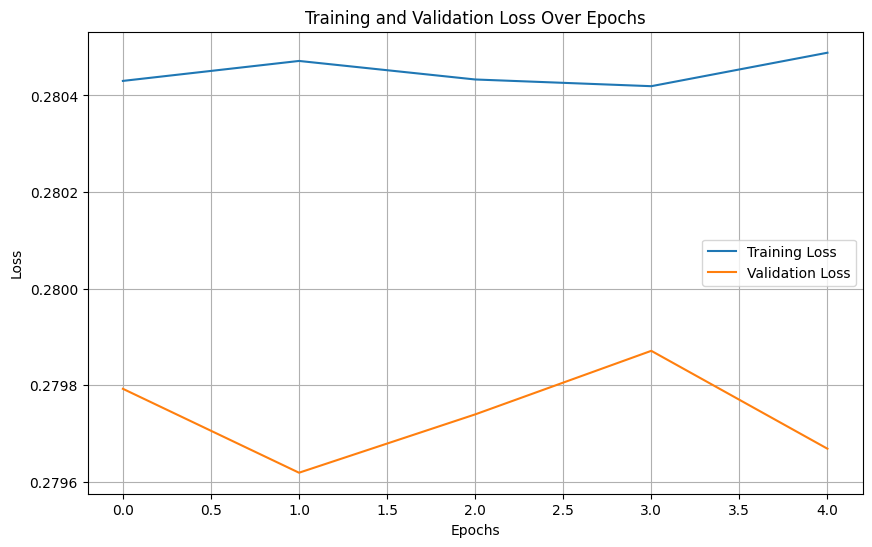

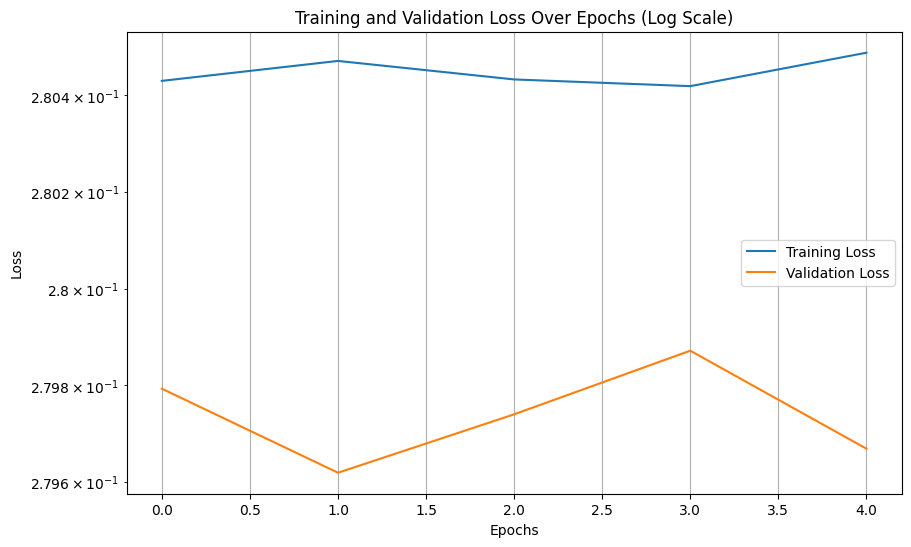

100%|██████████| 2/2 [00:00<00:00,  4.09batches/s]


Epoch [6/326] - Train Loss: 0.2805, Val Loss: 0.2797


100%|██████████| 2/2 [00:00<00:00,  9.85batches/s]


Epoch [7/326] - Train Loss: 0.2804, Val Loss: 0.2799


100%|██████████| 2/2 [00:00<00:00,  9.26batches/s]


Epoch [8/326] - Train Loss: 0.2804, Val Loss: 0.2797


 50%|█████     | 1/2 [00:00<00:00,  3.06batches/s]


KeyboardInterrupt: 

In [96]:
conv_rbm_64.train_rbm(
    train_loader=train_loader_64, 
    val_loader=val_loader_64,
    epochs=326, 
    device=DEVICE,
    save_interval=5,
    )